![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Pytorch_logo.png/800px-Pytorch_logo.png)

In [8]:
# conda create -n my_env python=3.9
# conda activate my_env

# conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
# conda install lightning -c conda-forge  ## 2.3
# pip install pandas
# pip install matplotlib
# pip install torchmetrics

In [9]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch.nn.functional as F
from torchvision import transforms

from lightning import LightningModule, Trainer, seed_everything
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch.callbacks import ModelCheckpoint

from torchmetrics import Accuracy
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

In [10]:
seed_everything(42, workers=True)

num_epochs = 5
batch_size = 64
lr = 1e-4

Seed set to 42


In [11]:
# Create a train and test dataset using the Pytorch MNIST dataloader class
# This inbuilt class will download the MNIST dataset to the provided "root" directory

# Input Parameters:
# root: the directory the dataset is in/should be downloaded to
# train: is this the train split or not? if not it's the test split
# download: if it can't find the dataset in the provided directory should it download the dataset?
# transform: the transform/augmentation to perform on the image data, the images are loaded as PIL images
# so we need to at least convert them to tensors (Pytorch has MANY different data augmentations)
dataset_train = MNIST(root='.', train=True,  download=True, transform=transforms.ToTensor())
dataset_test  = MNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

# Using the Pytorch dataloader class and the Pytorch datasets we with create itterable dataloader objects
data_loader_train = DataLoader(dataset_train, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=False)
data_loader_test = DataLoader(dataset_test, shuffle=False, batch_size=batch_size, num_workers=0, pin_memory=False)

# NOTE:num_workers is the number of extra threads the dataloader will spawn to load the data from file,
# you will rarely need more than 4
# NOTE!!! ON WINDOWS THERE CAN BE ISSUES WITH HAVING MORE THAN 0 WORKERS!! IF YOUR TRAINING LOOP STALLS AND DOES
# NOTHING SET num_workers TO 0!

# NOTE:pin_memory is only useful if you are training with a GPU!!!! If it is True then the GPU will pre-allocate
# memory for the NEXT batch so the CPU-GPU transfer can be handled by the DMA controller freeing up the CPU

In [12]:
print("Train DataSET size:", len(dataset_train))
print("Test DataSET size:", len(dataset_test))

Train DataSET size: 60000
Test DataSET size: 10000


In [13]:
print("Train DataLOADER size:", len(data_loader_train))
print("Test DataLOADER size:", len(data_loader_test))

Train DataLOADER size: 938
Test DataLOADER size: 157


In [14]:
len(dataset_train)/batch_size

937.5

In [15]:
# The DataLOADER will loop through a batch of indices and provide them to the dataSET one at a time
# and will "batch" together all the datapoints along the "batch dimension" (dim 0) returning a single tensor
train_data_iter = iter(data_loader_train)
data, labels = next(train_data_iter)
print("Input Data shape", data.shape)
print("Target Data shape", labels.shape)

Input Data shape torch.Size([64, 1, 28, 28])
Target Data shape torch.Size([64])


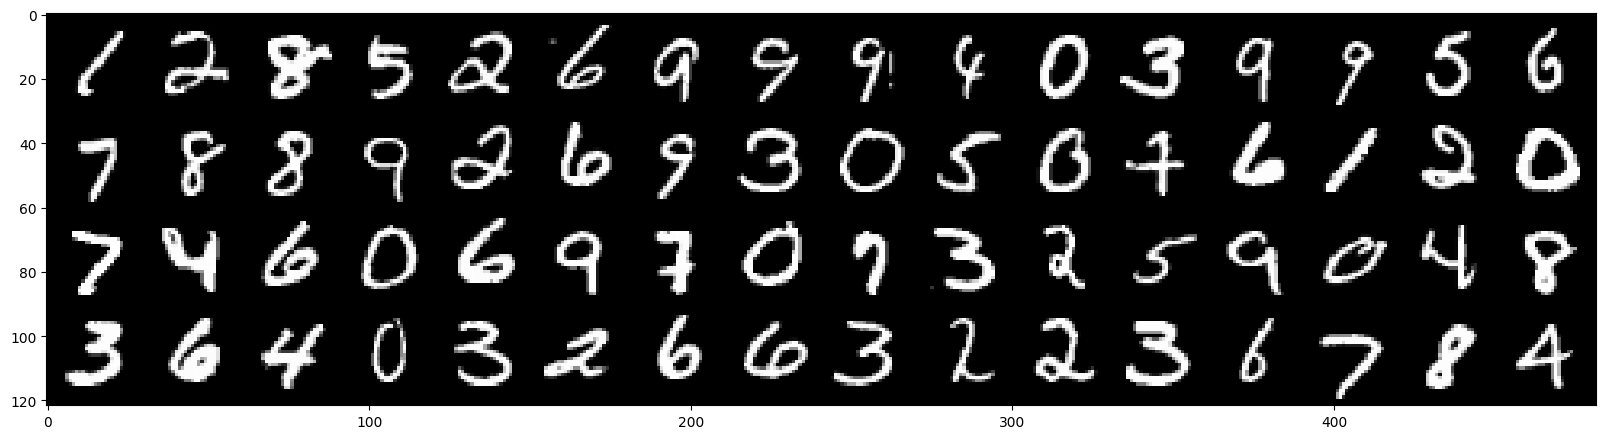

In [16]:
#Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(data, nrow=16)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [17]:
class SimpleMLP(LightningModule):
    def __init__(self, input_size, output_size, hidden_sizes, loss_func, learning_rate=1e-3):
        super().__init__()

        # Set our init args as class attributes
        self.learning_rate = learning_rate
        self.loss_fn = loss_func

        # call this to save (learning_rate=1e-3) to the checkpoint
        self.save_hyperparameters()

        # Create the same layers as before!
        self.fc_1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc_2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc_3 = nn.Linear(hidden_sizes[1], output_size)

        # We'll use a torchmetrics "Accuracy" object to calculate the accuracies while we train!
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        # The forward pass is exactly the same as before!

        # The data we pass the model is a batch of single channel images
        # with shape BSx1x28x28 we need to flatten it to BSx784
        # To use it in a linear layer
        bs = x.shape[0]
        x = x.reshape(bs, -1)

        # We will use a relu activation function for this network! (F.relu)
        # NOTE F.relu is the "functional" version of the activation function!
        # nn.ReLU is a class constructor of a "ReLU" object
        # These two things are the same for MOST purposes!
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))

        # NO activation function on the output!
        # The loss function we will use (nn.CrossEntropyLoss) incorporates a SoftMax
        # into the loss to and ensures stability!
        x = self.fc_3(x)
        return x

    def training_step(self, batch, batch_idx):
        # We need to define a single training step
        # all this function needs to do is perform a forward pass and calculate the loss
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.argmax(1)
        self.train_accuracy.update(preds, y)

        # logs metrics for each training epoch
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.argmax(1)
        self.val_accuracy.update(preds, y)

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)

        preds = logits.argmax(1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        # Choose what optimizers and learning-rate schedulers to use in your optimization.
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        # An iterable training samples.
        return data_loader_train

    def val_dataloader(self):
        return data_loader_test

    def test_dataloader(self):
        return data_loader_test

In [18]:
model = SimpleMLP(input_size=784, output_size=10, loss_func=nn.CrossEntropyLoss(), hidden_sizes=[128, 64])

trainer = Trainer(
    accelerator = "auto", # if your machine has GPUs, it will use the GPU Accelerator for training
    devices = "auto",
    max_epochs = num_epochs,
    callbacks = [TQDMProgressBar(refresh_rate=20)],
    logger = CSVLogger(save_dir="MNIST_test_1"),
    check_val_every_n_epoch=1, # run val loop every 1 training epoch
    deterministic=True, # makes training reproducible
)

trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | CrossEntropyLoss   | 0      | train
1 | fc_1           | Linear             | 100 K  | train
2 | fc_2           | Linear             | 8.3 K  | train
3 | fc_3           | Linear             | 650    | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
5 | train_accuracy | MulticlassAccuracy | 0      | train
6 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.438     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(model)

c:\Users\jiunh\anaconda3\envs\ECE4179\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9750999808311462
        test_loss           0.08101999014616013
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.08101999014616013, 'test_acc': 0.9750999808311462}]

In [ ]:
traing_data = pd.read_csv(trainer.logger.log_dir + "/metrics.csv")
traing_data.set_index("epoch", inplace=True)
traing_data = traing_data.groupby(level=0).sum().drop("step", axis=1)

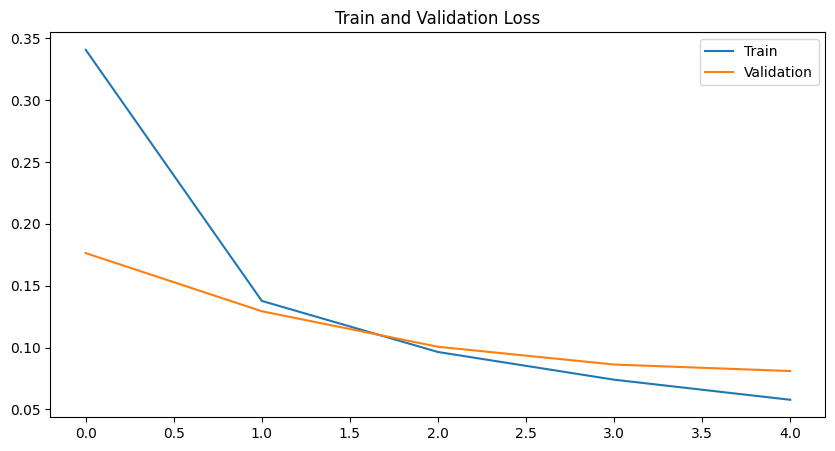

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(traing_data["train_loss"][:-1])
plt.plot(traing_data["val_loss"][:-1])

plt.title("Train and Validation Loss")
_ = plt.legend(["Train", "Validation"])

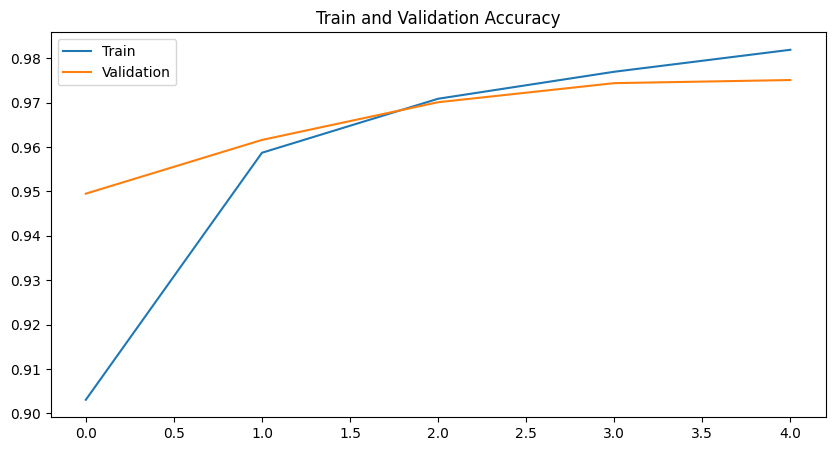

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(traing_data["train_acc"][:-1])
plt.plot(traing_data["val_acc"][:-1])

plt.title("Train and Validation Accuracy")
_ = plt.legend(["Train", "Validation"])